# Tutorial 4: Training a spiking neural network on a spiking dataset (Spiking Heidelberg Digits)

Manu Srinath Halvagal (https://zenkelab.org/team/) and Friedemann Zenke (https://fzenke.net)

For more details on surrogate gradient learning, please see: 

> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks: Bringing the Power of Gradient-based optimization to spiking neural networks. IEEE Signal Process Mag 36, 51–63.
> https://ieeexplore.ieee.org/document/8891809 and https://arxiv.org/abs/1901.09948

> Cramer, B., Stradmann, Y., Schemmel, J., and Zenke, F. (2020). The Heidelberg Spiking Data Sets for the Systematic Evaluation of Spiking Neural Networks. IEEE Transactions on Neural Networks and Learning Systems 1–14. 
> https://ieeexplore.ieee.org/document/9311226 and https://arxiv.org/abs/1910.07407"

In Tutorials 2 and 3, we have seen how to train a multi-layer spiking neural network on the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) along with an activity regularizer. However, the spiking activity input to the network was generated using a simple time-to-first-spike code. Here we apply the model to train a spiking network to learn the Spiking Heidelberg Digits dataset (https://compneuro.net/posts/2019-spiking-heidelberg-digits/). This dataset uses a more sophisticated cochlear model to generate the spike data corresponding to audio recordings of spoken digits (examples below).

![Image of Yaktocat](https://compneuro.net/img/hdspikes_digits_samples.png)

In [2]:
import os
import h5py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
from torch.utils import data

from utils import get_shd_dataset

In [3]:
# The coarse network structure and the time steps are dicated by the SHD dataset. 
nb_inputs  = 700
nb_hidden  = 200
nb_outputs = 20

time_step = 1e-3
nb_steps = 100
max_time = 1.4

batch_size = 256

In [4]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

### Setup of the spiking dataset

In [6]:
# Here we load the Dataset
cache_dir = os.path.expanduser("~/data")
cache_subdir = "hdspikes"
get_shd_dataset(cache_dir, cache_subdir)

train_file = h5py.File(os.path.join(cache_dir, cache_subdir, 'shd_train.h5'), 'r')
test_file = h5py.File(os.path.join(cache_dir, cache_subdir, 'shd_test.h5'), 'r')

x_train = train_file['spikes']
y_train = train_file['labels']
x_test = test_file['spikes']
y_test = test_file['labels']

File shd_train.h5.gz decompressed to:
C:\Users\Deepti Kumar/data\hdspikes\shd_train.h5.gz
File shd_test.h5.gz decompressed to:
C:\Users\Deepti Kumar/data\hdspikes\shd_test.h5.gz


The code for learning the SHD dataset is nearly identical to what we have seen for the FashionMNIST dataset in the last two tutorials. An important difference is that, now, we have the input data already in the form of spikes. This is reflected in the sparse_data_generator below. 

In order to use the data for learning with our spiking network, we also need to discretize the spike times into n_steps bins. Note the additional max_time argument (~1.4 for SHD) that forms the upper limit of the bins.

In [7]:
def sparse_data_generator_from_hdf5_spikes(X, y, batch_size, nb_steps, nb_units, max_time, shuffle=True):
    """ This generator takes a spike dataset and generates spiking network input as sparse tensors. 

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=np.int)
    number_of_batches = len(labels_)//batch_size
    sample_index = np.arange(len(labels_))

    # compute discrete firing times
    firing_times = X['times']
    units_fired = X['units']
    
    time_bins = np.linspace(0, max_time, num=nb_steps)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        coo = [ [] for i in range(3) ]
        for bc,idx in enumerate(batch_index):
            times = np.digitize(firing_times[idx], time_bins)
            units = units_fired[idx]
            batch = [bc for _ in range(len(times))]
            
            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)
    
        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index],device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

### Setup of the spiking network model

In [8]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

Let's also now include recurrent weights in the hidden layer. This significantly improves performance on the SHD dataset .

In [9]:
weight_scale = 0.2

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

v1 = torch.empty((nb_hidden, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(v1, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


In [10]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

In [11]:
from IPython.display import clear_output

def live_plot(loss):
    if len(loss) == 1:
        return
    clear_output(wait=True)
    ax = plt.figure(figsize=(3,2), dpi=150).gca()
    ax.plot(range(1, len(loss) + 1), loss)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.xaxis.get_major_locator().set_params(integer=True)
    sns.despine()
    plt.show()

## Training the network

In [12]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

run_snn is also changed now in order to include the recurrent input in the hidden layer computation.

In [13]:
def run_snn(inputs):
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    out = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
    h1_from_input = torch.einsum("abc,cd->abd", (inputs, w1))
    for t in range(nb_steps):
        h1 = h1_from_input[:,t] + torch.einsum("ab,bc->ac", (out, v1))
        mthr = mem-1.0 #1 is the threshold potential
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1
        new_mem =(beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [20]:
def train(x_data, y_data, lr=1e-3, nb_epochs=10):
    
    params = [w1,w2,v1]
    optimizer = torch.optim.Adamax(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size, nb_steps, nb_inputs, max_time):
            output,recs = run_snn(x_local.to_dense())
            _,spks=recs
            m,_=torch.max(output,1)
            log_p_y = log_softmax_fn(m)
            
            # Here we set up our regularizer loss
            # The strength paramters here are merely a guess and there should be ample room for improvement by
            # tuning these paramters.
            reg_loss = 2e-6*torch.sum(spks) # L1 loss on total number of spikes
            reg_loss += 2e-6*torch.mean(torch.sum(torch.sum(spks,dim=0),dim=0)**2) # L2 loss on spikes per neuron
            
            # Here we combine supervised loss and the regularizer
            y_local = y_local.type(torch.LongTensor)
            loss_val = loss_fn(log_p_y, y_local) + reg_loss

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        loss_hist.append(mean_loss)
        live_plot(loss_hist)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        
    return loss_hist
        
        
def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size, nb_steps, nb_inputs, max_time, shuffle=False):
        output,_ = run_snn(x_local.to_dense())
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [21]:
nb_epochs = 200

WARNING: Training for a large number of epochs could take a significant amount of time. Reduce the nb_epochs parameter as necessary.

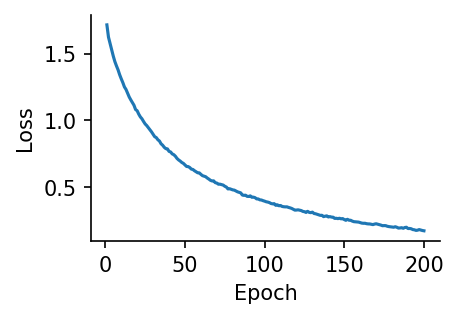

Epoch 200: loss=0.17261


In [24]:
loss_hist = train(x_train, y_train, lr=2e-4, nb_epochs=nb_epochs)
#loss_hist = train(x_train, y_train, lr=2e-4, nb_epochs=20)

In [25]:
print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train,y_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test)))

C:\Users\DEEPTI~1\AppData\Local\Temp/ipykernel_15920/3193409431.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels_ = np.array(y,dtype=np.int)


Training accuracy: 0.992
Test accuracy: 0.635


In [26]:
def get_mini_batch(x_data, y_data, shuffle=False):
    for ret in sparse_data_generator_from_hdf5_spikes(x_data, y_data, batch_size, nb_steps, nb_inputs, max_time, shuffle=shuffle):
        return ret 

In [27]:
x_batch, y_batch = get_mini_batch(x_test, y_test)
output, other_recordings = run_snn(x_batch.to_dense())
mem_rec, spk_rec = other_recordings

C:\Users\DEEPTI~1\AppData\Local\Temp/ipykernel_15920/3193409431.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels_ = np.array(y,dtype=np.int)


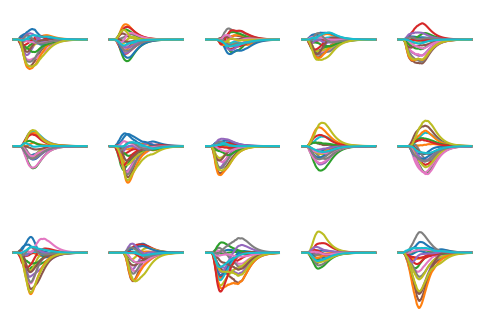

In [28]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

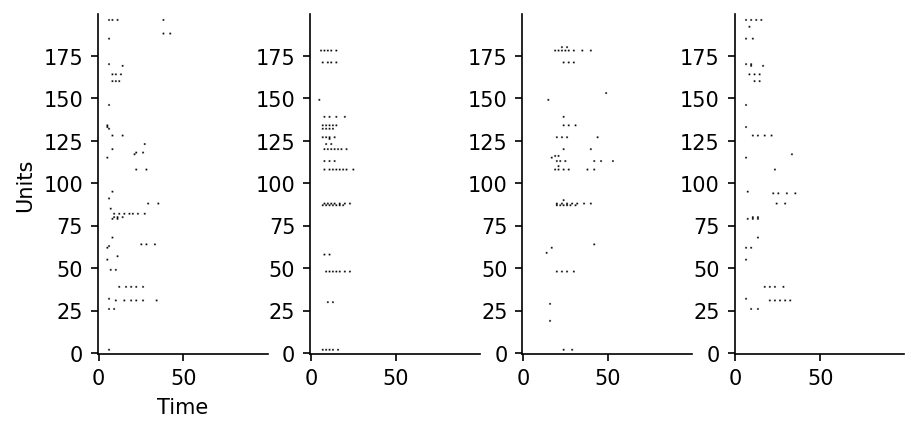

In [29]:
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()

We see that spiking in the hidden layer is quite sparse as in the previous Tutorial 3 because we used the same activity regularizer.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.